# Clasificador de texto con Redes Neuronales Recurrentes
Implementemos un clasificador con RNN aplicada al análisis de sentimiento en Twitter.  
Probamos tres aproximaciones diferentes para calcular los embeddings de entrada:  
- Primero probamos los *word embeddings* de Spacy (modelo GloVe) sin actualizar
- Luego usamos los *word embeddings* de Spacy para hacer Transfer Learning (actualizando los pesos en el entrenamiento)
- Por último probamos entrenando los embeddings con nuestro propio texto.  
  
Probamos dos tipos de RNN diferentes:  
- LSTM (Long Short-Term Memory)
- GRU (Gated Recurrent Unit)

Usamos KERAS (en la distribución de TensorFlow 2)

In [1]:
import pandas as pd
pd.options.display.max_colwidth = None
import numpy as np
import re, string, spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

2024-08-13 08:41:24.955103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Definimos características de la capa RNN

RNN_DIM = 50 #Nº de neuronas en la capa RNN
RNN_layer = LSTM #usar GRU o LSTM

In [3]:
# Leemos los datos
df = pd.read_csv('tweets_max.csv', index_col=None)

#seleccionamos columnas de interés
df = df[['content', 'polarity']]

#dejamos polaridades definidas
df = df[(df['polarity']=='P') | (df['polarity']=='N')]

df.head()

,content,polarity
0,"@myendlesshazza a. que puto mal escribo b. me sigo surrando help 3. ha quedado raro el ""cómetelo"" ahí JAJAJAJA",N
1,Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps,P
2,Vale he visto la tia bebiendose su regla y me hs dado muchs grima,N
3,@Yulian_Poe @guillermoterry1 Ah. mucho más por supuesto! solo que lo incluyo. Me habías entendido mal,P
4,@toNi_end seria mejor que dejasen de emitir esa basura ya hay que evolucionar para bien y eso,N


In [4]:
df.polarity.value_counts()

polarity
N    840
P    609
Name: count, dtype: int64

## Limpieza de texto
Usamos Spacy para separar el texto en tokens y mantener sólo las palabras importantes, dejando su lemma

In [5]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

## Preparemos el conjunto de datos
Fijamos un tamaño máximo de vocabulario.  
Separamos los tweets en tokens dentro de este vocabulario y creamos las secuencias de longitud fija.  
La longitud de la secuencia viene dada por la longitud en tokens del tweet más largo. Sólo se conservan los tokens de las palabras en el vocabulario.

In [6]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.content=df.content.apply(clean_text, lemas=True)
df = df[df['content']!='']

#el conjunto de salida es la polaridad, hay que convertir a numérico para Keras
#codificamos 'P' como 1 y 'N' se queda como 0
Y=(df.polarity=='P').values*1

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.content,Y, 
    test_size = 0.3,
    random_state = 0)

In [7]:
#Estimamos el tamaño de vocabulario (parabras con un min_df de 2 en TRAIN)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=2)
cv.fit(tweets_train)
max_features = len(cv.get_feature_names_out())
print(f'Tamaño vocabulario: {format(max_features)} palabras')

Tamaño vocabulario: 1014 palabras


Creamos tokens del texto usando sólo el vocabulario del conjunto de entrenamiento y aplicando en test

In [8]:
MAX_NB_WORDS = max_features+2 #hay que considerar 1 término más para el OOV y otro para el 0
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ', oov_token='OOV')
tokenizer.fit_on_texts(tweets_train.values)
X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
MAX_SEQUENCE_LENGTH = X_train.shape[1]

X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
# Note that you could "pre" padding (at the beginning) or
# "post" padding (at the end).
# We recommend using "post" padding when working with RNN layers
# (in order to be able to use the 
# CuDNN implementation of the layers).

Found 3221 unique tokens.


In [9]:
MAX_NB_WORDS

1016

In [10]:
np.max(X_train)

1015

In [11]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1014, 33) (1014,)
(435, 33) (435,)


In [12]:
X_train[0]

array([ 73,  26,   1, 169,   4, 133, 143,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [13]:
tokenizer.word_index['OOV']

1

## Transfer Learning con Word Embeddings de GloVe
Usamos los Embeddings ya calculados en la librería `spaCy`
### Calculamos los word embeddings
Vamos a entrenar el modelo secuencial con los tweets, donde cada tweet será una secuencia.  
Cada palabra de cada tweet se convierte en un vector (word_embedding) de 300 dimensiones. Usamos los vectores precalculados del modelo del Spacy.  
Hace falta que todas las secuencias tengan la misma longitud, así que usamos la longitud del tweet más largo y rellenamos con ceros los vectores de las palabras que no existen.  
Rellenamos por la izquierda para que las últimas palabras de entrada a la red nunca estén vacías.  
Fijamos una longitud del tweet de max_length palabras. Cada vector tiene 300 elementos, por lo que cada muestra de entrada a la red LSTM es una matriz de tamaño max_length x 300.  
Hay 733 muestras por lo que la matriz total de datos X tendrá un tamaño 733 x max_length x 300.  

Como hemos limitado el vocabulario a `max_features` términos, los tokens de las secuencias codificadas tienen índices del 0 al `max_features+1` (donde el 0 es 'Secuencia vacía') y el 1 es 'OOV') y por tanto necesitamos una matriz de embeddings de `max_features+2` x 300 dimensiones

In [14]:
#Rellenamos los vectores con el valor en spaCy para la MAX_NB_WORDS palabras más frecuentes
nlp=spacy.load('es_core_news_md')


EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
vectores = 0
for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        if nlp.vocab[word].has_vector:
            # las palabras que no están en spaCy serán cero.
            embedding_matrix[i] = nlp.vocab[word].vector
            vectores += 1
        
print(f"Cargados {vectores} vectores en la matriz")

Cargados 968 vectores en la matriz


In [15]:
embedding_matrix.shape

(1016, 300)

### Modelo con embeddings fijos Glove

In [16]:
#Creamos el modelo RNN en Keras usando los embeddings cargados como pesos
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(RNN_DIM, dropout=0.2, recurrent_dropout=0.2)) #no usamos recurrent_dropout=0.2 por problemas con el M1
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 300)           304800    
                                                                 
 spatial_dropout1d (SpatialD  (None, 33, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 375,051
Trainable params: 70,251
Non-trainable params: 304,800
_________________________________________________________________
None


In [17]:
batch_size=16
history=model.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test))

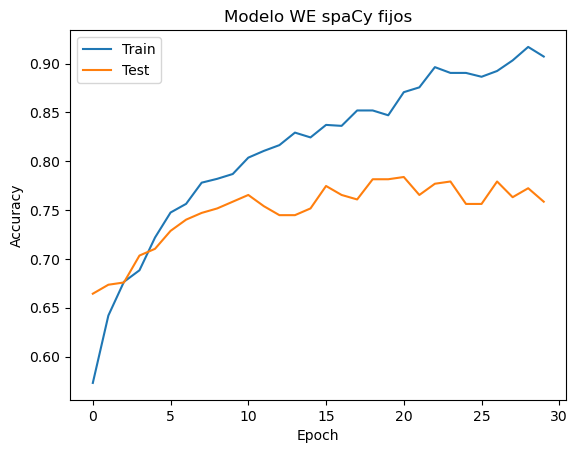

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE spaCy fijos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

28/28 - 1s - loss: 0.6275 - accuracy: 0.7586 - 653ms/epoch - 23ms/step
score: 0.63
acc: 0.76


In [20]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 8s 18ms/step
              precision    recall  f1-score   support

           N       0.81      0.78      0.79       259
           P       0.69      0.72      0.71       176

    accuracy                           0.76       435
   macro avg       0.75      0.75      0.75       435
weighted avg       0.76      0.76      0.76       435



### Modelo con fine-tuning
Vamos a probar a re-entrenar los vectores de spaCy con nuestros documentos (parámetro `trainable` a `True`)

In [21]:
embedding_layer2 = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

model2 = Sequential()
model2.add(embedding_layer2)
model2.add(SpatialDropout1D(0.4))
model2.add(RNN_layer(RNN_DIM, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 300)           304800    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 33, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 375,051
Trainable params: 375,051
Non-trainable params: 0
_________________________________________________________________
None


Observa que ahora todos los parámetros son del tipo `Trainable` incluyendo los de la capa de Embedding.  
### Ejercicio 1
Entrena el nuevo modelo `model2` con los mismos parámetros del anterior, y guarda el resultado en la variable `history`

In [22]:
## Solución
history=model2.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test))

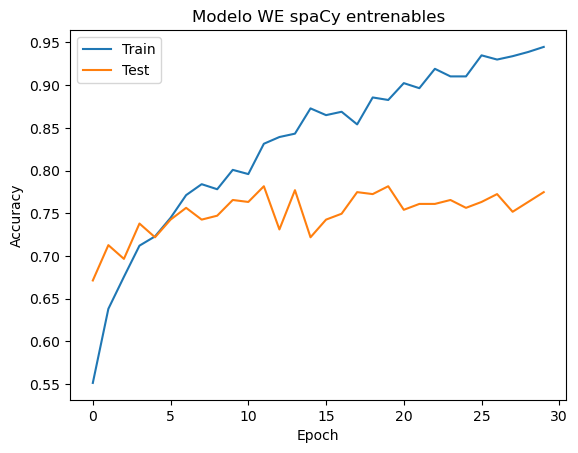

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE spaCy entrenables')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
score,acc = model2.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.66
acc: 0.77


In [25]:
predict=model2.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 13s 29ms/step
              precision    recall  f1-score   support

           N       0.81      0.81      0.81       259
           P       0.72      0.72      0.72       176

    accuracy                           0.77       435
   macro avg       0.77      0.77      0.77       435
weighted avg       0.77      0.77      0.77       435



## Modelo con embeddings propios
Usamos sólo nuestros documentos para generar los embeddings sin entrenamiento previo.

In [26]:
#Creamos el modelo LSTM en Keras

model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH, mask_zero=True))
model3.add(SpatialDropout1D(0.4))
model3.add(RNN_layer(RNN_DIM, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 300)           304800    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 33, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 50)                70200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 375,051
Trainable params: 375,051
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history=model3.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test))

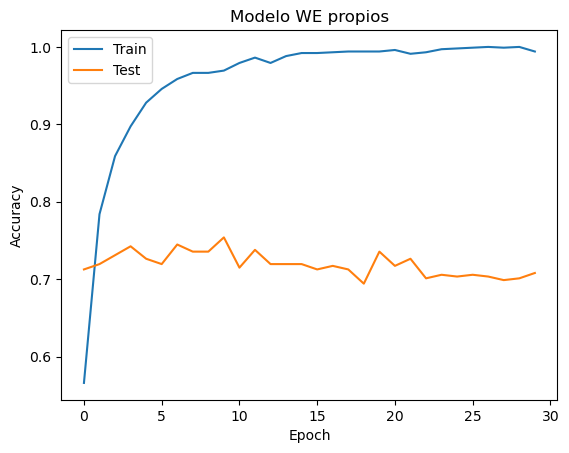

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE propios')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
score,acc = model3.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.64
acc: 0.71


In [30]:
predict=model3.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 11s 24ms/step
              precision    recall  f1-score   support

           N       0.77      0.73      0.75       259
           P       0.63      0.68      0.65       176

    accuracy                           0.71       435
   macro avg       0.70      0.70      0.70       435
weighted avg       0.71      0.71      0.71       435



### Modelo con embeddings aleatorios sin re-entrenar
Probamos a entrenar un nuevo modelo con valores de WE aleatorios (sin entrenar) para ver cuánta mejora suponen los WE entrenados.  
El modelo con WE propios ya utiliza una inicialización aleatoria por lo que no lo repetimos aquí.  

In [31]:
#Rellenamos los vectores con valores aleatorios

EMBEDDING_DIM=50
embedding_matrix_rand = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
vectores = 0
for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        embedding_matrix_rand[i] = np.random.normal(size=EMBEDDING_DIM)

In [32]:
#Creamos el modelo RNN en Keras usando los embeddings cargados como pesos
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_rand],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(RNN_layer(RNN_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 50)            50800     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 33, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 20,251
Non-trainable params: 50,800
_________________________________________________________________
None


In [33]:
history=model.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test))

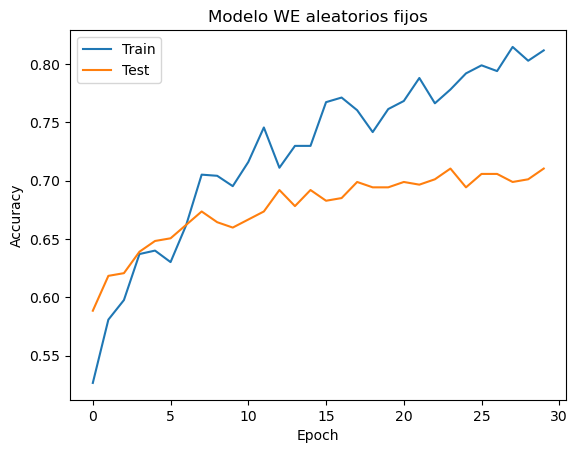

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE aleatorios fijos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
score,acc = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.66
acc: 0.71


In [36]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 11s 24ms/step
              precision    recall  f1-score   support

           N       0.73      0.81      0.77       259
           P       0.67      0.57      0.61       176

    accuracy                           0.71       435
   macro avg       0.70      0.69      0.69       435
weighted avg       0.71      0.71      0.71       435



## Optimización del modelo
El mejor modelo es que usa los WE pre-entrenados con Transfer Learning. No obstante, se podría mejorar limitando algo el sobre-entrenamiento con mayor dropout y ajustando mejor el número de unidades LSTM. Además, usamos el método checkpoint para quedarnos con la época de mejor resultado en validación

In [37]:
EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        embedding_vector = nlp.vocab[word].vector
        if not np.array_equal(embedding_vector, np.zeros(EMBEDDING_DIM)):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
embedding_layer2 = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

RNN_DIM = 50
model_final = Sequential()
model_final.add(embedding_layer2)
model_final.add(SpatialDropout1D(0.4))
model_final.add(RNN_layer(RNN_DIM, dropout=0.5, recurrent_dropout=0.4))
model_final.add(Dense(1, activation='sigmoid'))
model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_final.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 33, 300)           304800    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 33, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 50)                70200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 375,051
Trainable params: 375,051
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
batch_size=16
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model_final.fit(X_train, Y_train, epochs=40, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list)


Epoch 1: val_accuracy improved from -inf to 0.60460, saving model to weights.best.hdf5

Epoch 2: val_accuracy improved from 0.60460 to 0.62989, saving model to weights.best.hdf5

Epoch 3: val_accuracy improved from 0.62989 to 0.67126, saving model to weights.best.hdf5

Epoch 4: val_accuracy improved from 0.67126 to 0.69655, saving model to weights.best.hdf5

Epoch 5: val_accuracy improved from 0.69655 to 0.69885, saving model to weights.best.hdf5

Epoch 6: val_accuracy improved from 0.69885 to 0.72414, saving model to weights.best.hdf5

Epoch 7: val_accuracy did not improve from 0.72414

Epoch 8: val_accuracy did not improve from 0.72414

Epoch 9: val_accuracy improved from 0.72414 to 0.73333, saving model to weights.best.hdf5

Epoch 10: val_accuracy improved from 0.73333 to 0.73793, saving model to weights.best.hdf5

Epoch 11: val_accuracy improved from 0.73793 to 0.75402, saving model to weights.best.hdf5

Epoch 12: val_accuracy did not improve from 0.75402

Epoch 13: val_accuracy d

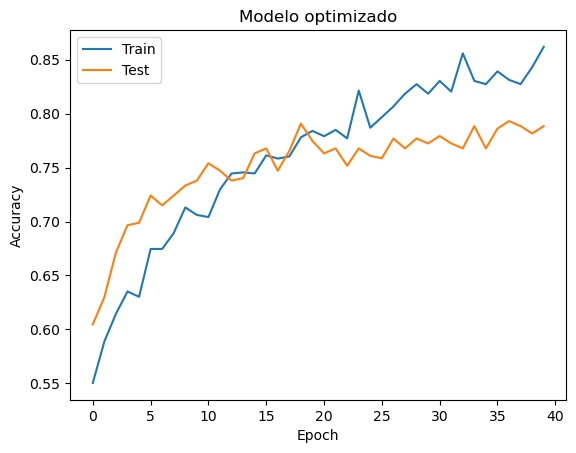

In [39]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo optimizado')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
score,acc = model_final.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.60
acc: 0.79


In [41]:
#cargamos el mejor modelo
model_final.load_weights("weights.best.hdf5")
score,acc = model_final.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.57
acc: 0.79


In [42]:
predict=model_final.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 9s 20ms/step
              precision    recall  f1-score   support

           N       0.81      0.85      0.83       259
           P       0.77      0.70      0.73       176

    accuracy                           0.79       435
   macro avg       0.79      0.78      0.78       435
weighted avg       0.79      0.79      0.79       435



## Inferencia en nuevos textos
Para hacer inferencia en nuevos textos hay que procesarlo con los mismos parámetros que hemos usado en el entrenamiento.

In [ ]:
twt = 'estoy triste con la mierda de partido'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='pre', value=0)
sentiment = model.predict(twt)
if(not np.round(sentiment)):
    print("negativo")
elif (np.round(sentiment)):
    print("positivo")

## Ejercicio 2
Repite el modelo óptimo cambiando el número de neuronas a 25 y 100 y compara los resultados. Repite de nuevo utilizando unidades GRU en lugar de LSTM y vuelve a analizar los resultados.

## Ejercicio 3
Repite el entrenamiento usando los WE de FastText descargados para el notebook de CNN y compara los resultados.